In [13]:
import numpy as np, pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

import os, time
import urllib.request 

from biopandas.pdb import PandasPdb
import blosum as bl

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import Levenshtein
from Levenshtein import distance as levenshtein_distance

In [14]:
base = "VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"

testCsvPath = "../novozymes-enzyme-stability-prediction-kaggle-2022/data/test.csv"
trainCsvPath = "../novozymes-enzyme-stability-prediction-kaggle-2022/data/train.csv"
pdbPath = "../novozymes-enzyme-stability-prediction-kaggle-2022/sample_data/wildtype_structure_prediction_af2.pdb"

testDF = pd.read_csv(testCsvPath)
trainDF = pd.read_csv(trainCsvPath)
pdbDF =  PandasPdb().read_pdb(pdbPath)

In [15]:
trainDF.values[:,1:]

array([['AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVGMIKDAGDDPDVTHGAEIQAFVRFASEDRLEGGEGVGVVTKPGLGVPVGEPAINPVPRRMIWEAVREVTERPLAVTIAIPGGEELAKKTLNPRLGILGGLSVLGTTGVVKPYSTSAFRMSVVQAVGVARANGLLEIAATTGGKSERFAQRLLPHLPEMAFIEMGDFVGDVLRAARKVGVEVVRVVGMIGKISKMADGKTMTHAAGGEVNLSLLLSLLKEAGASPKALKEAEGAATARRFLEIALEEGLELFFVNLVRLAQEKLQAYIGERPFVSVALTDFDEGRCLAAWPDREVYR',
        7.0, 'doi.org/10.1038/s41592-020-0801-4', 75.7],
       ['AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSRLQAQRRAQRVAWEDGDENVGQTVIPAQEEEGIEKPAEVHPTGKIGAKKLRKLEEKQARKAQREAEEAEREERKRLESQREAEWKKEEERLRLKEEQKEEEERKAQEEQARREHEEYLKLKEAFVVEEEGVSETMTEEQSHSFLTEFINYIKKSKVVLLEDLAFQMGLRTQDAINRIQDLLTEGTLTGVIDDRGKFIYITPEELAAVANFIRQRGRVSITELAQASNSLISWGQDLPAQAS',
        7.0, 'doi.org/10.1038/s41592-020-0801-4', 50.5],
       ['AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYATLGVAKNANGKDIKKAYYQLAKKYHPDTNKEDPDAGRKFQEVSEAYEVLSDEQKRREYDTYGQTAENIGRQGGGFPGGGAGGFGPEGFSQSWQFRSSIDPEELFRKIFGEGNFRTNSFDDFADSKFGFGQAQEMVMDLTFAQAARGVNKDVNVNVVDQCPKCAGTKCEPGTKPGRCQYCN

In [16]:
len(base)

221

In [17]:
len_list = [len(trainDF.values[i,1]) for i in range(len(trainDF))]

In [18]:
trainDF.insert(2, "sequence_len", len_list)

In [24]:
df1 = trainDF[trainDF.sequence_len == 221]
df2 = trainDF[trainDF.sequence_len == 220]
df3 = trainDF[trainDF.sequence_len == 222]

singleDF = pd.concat([df1,df2,df3])

In [29]:
def build_change_list(group_df):
    
    list_output = []
    group_size = len(group_df)
    group_values = group_df.values
    
    col = ['sequence_len','pH','data_source','tm']

    for i in range(group_size):
        data1 = group_values[i]
        line1 = data1[1] # protein sequence
        values1  = data1[2:]
        for j in range(group_size):
            data2 = group_values[j]
            line2 = data2[1]
            values2  = data2[2:]
            if i!=j:
                edits = Levenshtein.editops(line1, line2)
                if len(edits)==1:
                    list_output.append(tuple([line1,line2])+edits[0]+tuple(line1[edits[0][1]])+tuple(line2[edits[0][1]])+ tuple(values1) + tuple(values2))
                else:
                    list_output.append(tuple([line1,line2])+('replace', 0, 0, 'A', 'A') + tuple(values1) + tuple(values2))

    changes = pd.DataFrame(list_output,columns=['seq1','seq2','operation','position1','position2','change1','change2']+[c+'1' for c in col] + [c+'2' for c in col])
    changes.change2 = np.where(changes.operation=='delete','',changes.change2)
    
    return changes

In [37]:
changes = build_change_list(singleDF)

In [ ]:
changes

In [42]:
# df_clean = changes[(changes.data_source1 == changes.data_source2)&(changes.pH1 == changes.pH2)]
# df_clean = df_clean[(df_clean.pH1>=6) & (df_clean.pH1<=8)]
df_clean = changes[changes.position1 != 0]

df_clean['target'] = df_clean['tm2'] - df_clean['tm1'] 

print(len(df_clean))
display(pd.crosstab(df_clean.change1,df_clean.change2).style.background_gradient(axis=None, cmap="YlGnBu"))

44


C:\Users\XTM233\AppData\Local\Temp\ipykernel_26680\3815420638.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['target'] = df_clean['tm2'] - df_clean['tm1']


change2,A,E,N,S,V
change1,,,,,
A,0,1,4,1,1
E,1,0,4,1,1
N,4,4,0,4,4
S,1,1,4,0,1
V,1,1,4,1,0


In [43]:
df_clean

,seq1,seq2,operation,position1,position2,change1,change2,sequence_len1,pH1,data_source1,tm1,sequence_len2,pH2,data_source2,tm2,target
16132,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,replace,166,166,A,E,222,7.8,10.1021/bi9929958,79.8,222,7.8,10.1021/bi9929958,103.0,23.2
16133,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,replace,166,166,A,N,222,7.8,10.1021/bi9929958,79.8,222,7.8,10.1021/bi972395d,85.3,5.5
16134,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,replace,166,166,A,N,222,7.8,10.1021/bi9929958,79.8,222,7.8,10.1021/bi9929958,90.7,10.9
16135,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,replace,166,166,A,N,222,7.8,10.1021/bi9929958,79.8,222,7.8,10.1021/bi972395d,90.7,10.9
16136,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,replace,166,166,A,N,222,7.8,10.1021/bi9929958,79.8,222,7.8,10.1021/bi972395d,57.4,-22.4
16137,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,replace,166,166,A,S,222,7.8,10.1021/bi9929958,79.8,222,7.8,10.1021/bi9929958,94.9,15.1
16138,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,replace,166,166,A,V,222,7.8,10.1021/bi9929958,79.8,222,7.8,10.1021/bi9929958,68.2,-11.6
16279,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,replace,166,166,E,A,222,7.8,10.1021/bi9929958,103.0,222,7.8,10.1021/bi9929958,79.8,-23.2
16280,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,replace,166,166,E,N,222,7.8,10.1021/bi9929958,103.0,222,7.8,10.1021/bi972395d,85.3,-17.7
16281,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQI...,replace,166,166,E,N,222,7.8,10.1021/bi9929958,103.0,222,7.8,10.1021/bi9929958,90.7,-12.3


In [44]:
avg_target = df_clean.groupby(['change1','change2']).target.mean()
display(avg_target.unstack().fillna(0).style.background_gradient(axis=None, cmap="RdYlBu").format('{:.2f}'))

change2,A,E,N,S,V
change1,,,,,
A,0.00,23.20,1.23,15.10,-11.60
E,-23.20,0.00,-21.98,-8.10,-34.80
N,-1.23,21.98,0.00,13.88,-12.82
S,-15.10,8.10,-13.88,0.00,-26.70
V,11.60,34.80,12.82,26.70,0.00


In [46]:
# compared to test data

def change_list(wild, mutation_list):

    list_output = []

    for mutation in mutation_list:
        edits = Levenshtein.editops(wild, mutation)
        if len(edits):
            list_output.append(edits[0]+tuple(mutation[edits[0][1]])+tuple(base[edits[0][1]]))
        else:
            list_output.append(('replace', 0, 0, 'A', 'A'))

    changes = pd.DataFrame(list_output,columns=['operation','position1','position2','change1','change2'])
    changes.change2 = np.where(changes.operation=='delete','',changes.change2)
    
    return changes

changes = change_list(base, testDF.protein_sequence.to_list())
changes.operation.value_counts()

replace    2336
delete       77
Name: operation, dtype: int64

<AxesSubplot: >

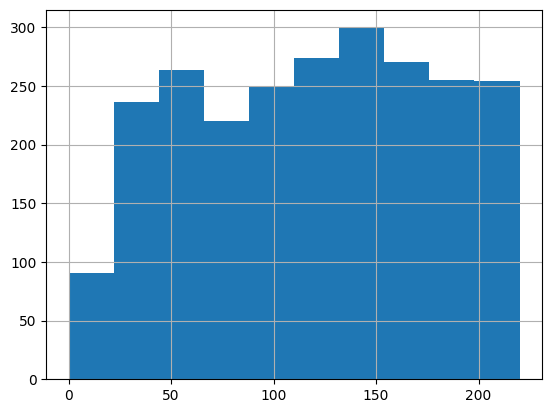

In [47]:
changes.position1.hist()

In [48]:
pd.crosstab(changes.change1,changes.change2).style.background_gradient(axis=None, cmap="YlGnBu")

change2,,A,D,E,F,G,I,K,L,N,P,Q,R,S,T,V,W,Y
change1,,,,,,,,,,,,,,,,,,
A,6,1,9,4,4,15,4,13,8,10,10,7,1,12,4,7,2,4
C,1,13,8,3,5,10,4,19,7,12,10,8,2,12,4,5,3,5
D,3,11,0,4,4,13,2,16,6,10,6,10,3,10,4,5,3,2
E,1,14,7,0,4,13,3,13,7,12,9,10,3,13,7,5,4,4
F,7,17,8,4,0,13,4,16,7,10,6,10,2,16,4,5,4,5
G,8,16,7,3,3,0,3,16,5,10,7,11,2,12,3,7,2,3
H,0,10,8,5,3,12,2,16,3,13,10,8,2,12,3,5,2,4
I,4,12,5,3,6,13,0,18,5,11,10,6,1,12,4,7,4,3
K,10,12,7,2,1,10,4,0,6,12,5,10,2,10,5,4,3,1


In [49]:
testDF.head

<bound method NDFrame.head of       seq_id                                   protein_sequence  pH  \
0      31390  VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   
1      31391  VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   
2      31392  VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...   8   
3      31393  VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   
4      31394  VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   
...      ...                                                ...  ..   
2408   33798  VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   
2409   33799  VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   
2410   33800  VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   
2411   33801  VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   
2412   33802  VPVNPEPDATSVENVWLKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   

     data_source  
0      Novozymes  
1      Novozymes  
2      Novozymes  
3      Novozymes  
4      Novozymes  
...